In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('webtraffic.csv')
print(data)

      Hour Index    Sessions
0              0  1418159421
1              1  1113769116
2              2   919158921
3              3   822352824
4              4   735526737
...          ...         ...
4891        4891  2555880561
4892        4892  2454084459
4893        4893  2405182410
4894        4894  2356280361
4895        4895  1987019991

[4896 rows x 2 columns]


In [3]:
data.shape

(4896, 2)

In [4]:
data.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


# Data Exploration for Web Traffic Forecasting



In [5]:
import matplotlib.pyplot as plt
sessions = data['Sessions'].values

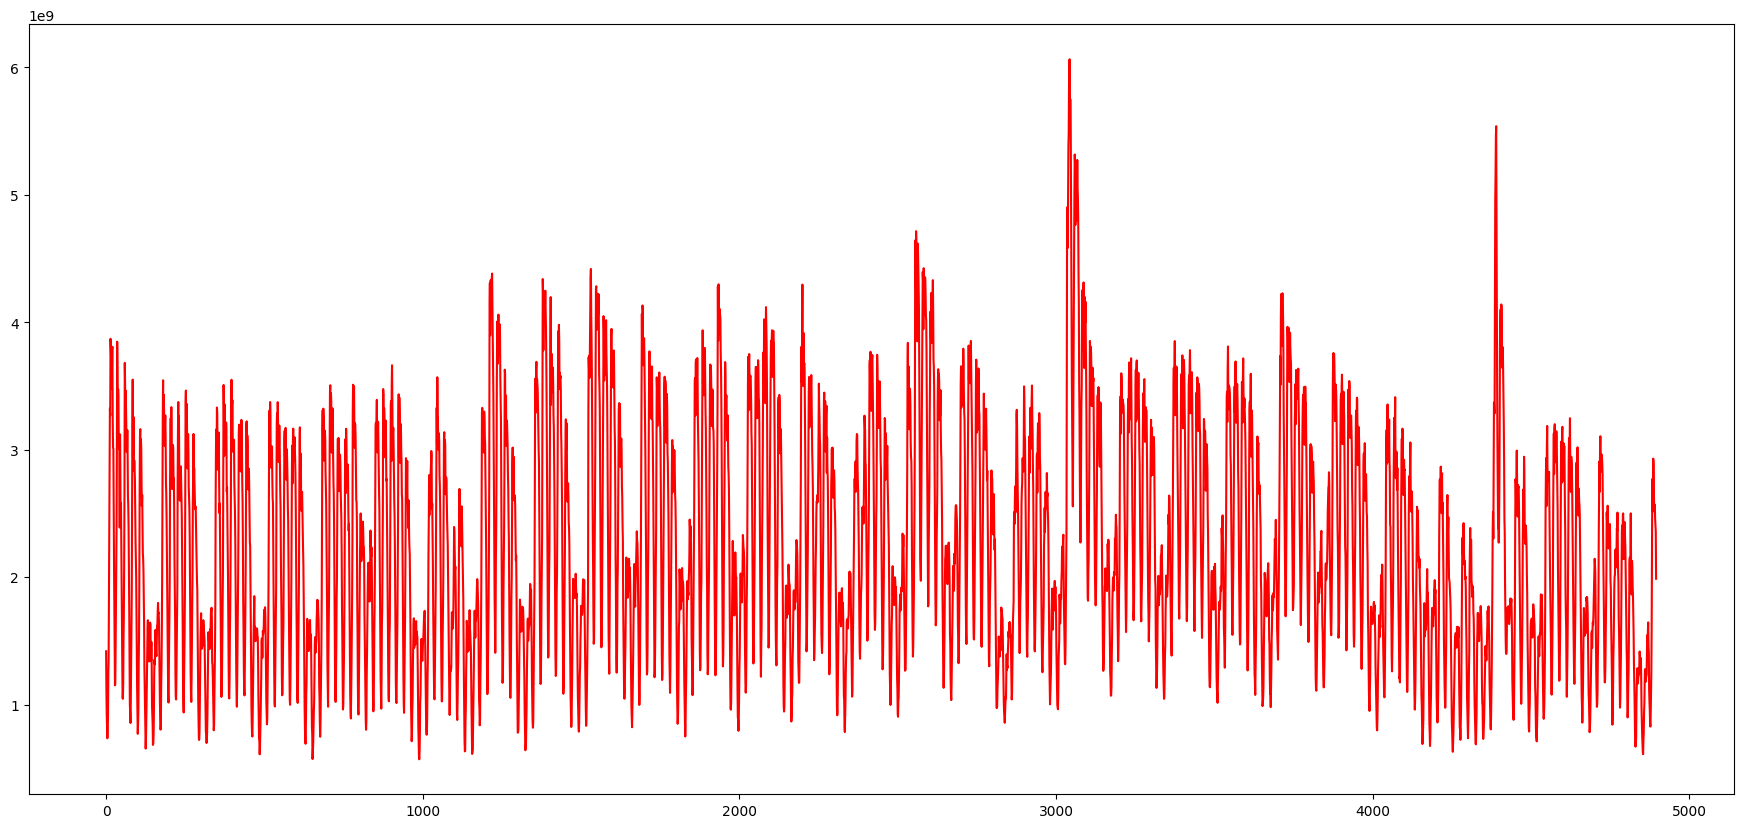

In [6]:
ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'r')
plt.show()


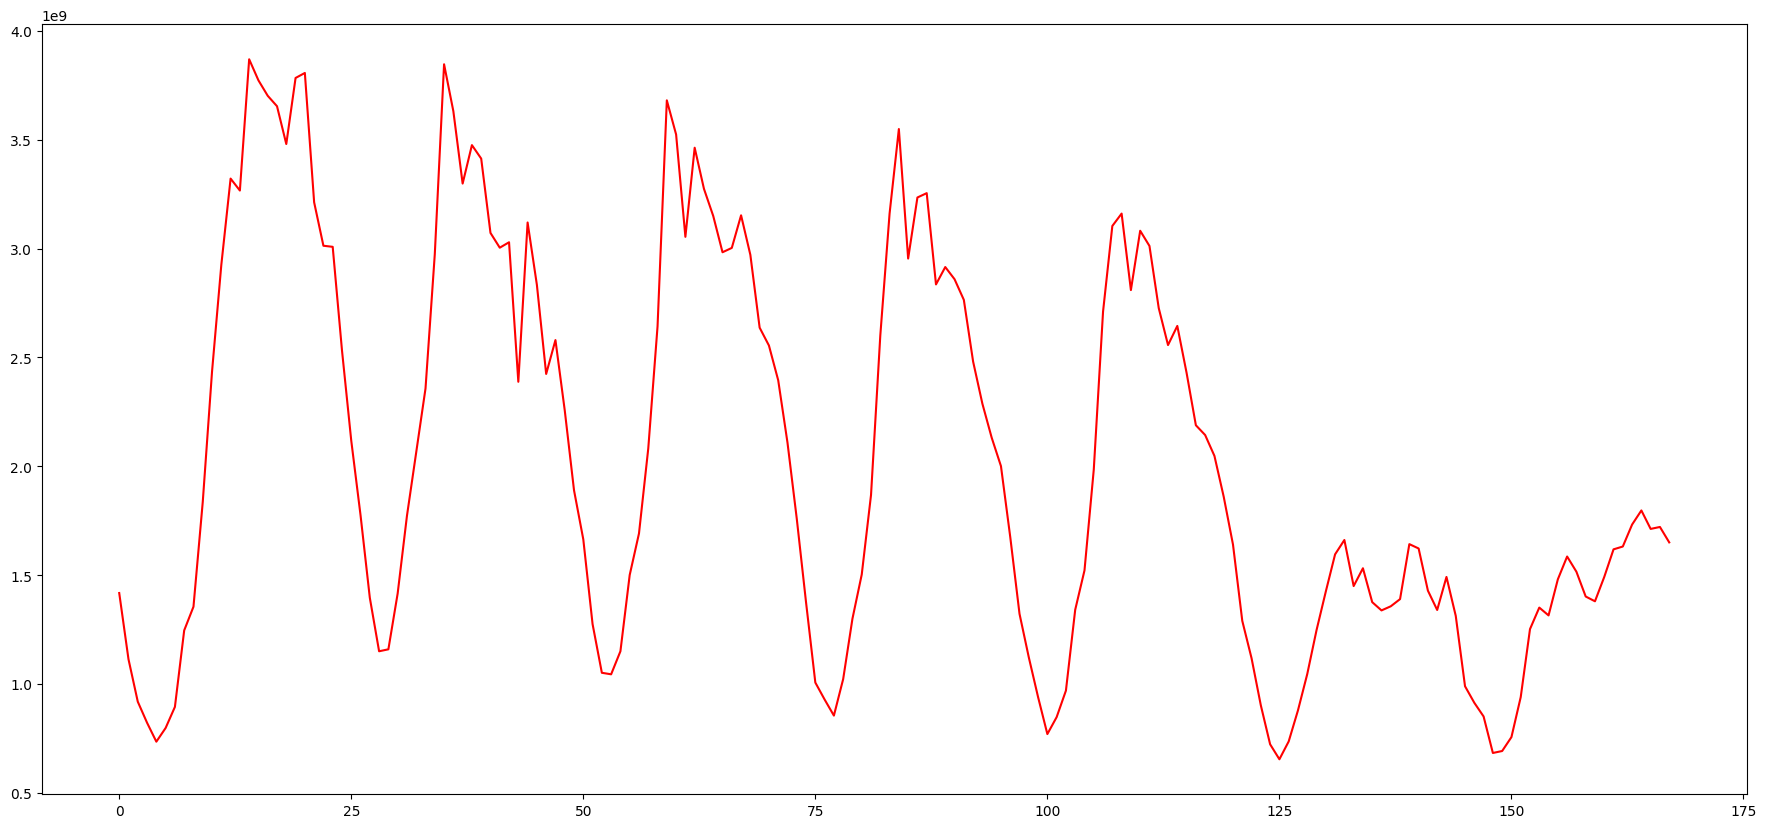

In [7]:
#Let’s explore this data, at a more granular level, and replacing the entire time series, with a subset of it.

#first week web traffic
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'r')
plt.show()

# Data Preparation for Web Traffic Forecasting

In [8]:
#let’s prepare the data for model training, here I have created input sequences, from the block traffic data.

def prepare_data(seq,num):
  x=[]
  y=[]
  for i in range(0,(len(seq)-num),1):
    
    input_ = seq[i:i+num]
    output  = seq[i+num]
    
    x.append(input_)
    y.append(output)
    
  return np.array(x), np.array(y)

In [9]:
#I have specified the sequence length of one week or 168 hours

num=168
x,y= prepare_data(sessions,num)
print(len(x))

4728


# Splitting the Dataset

In [10]:
#Next, I have split the data into a training set and validation set in the ratio, 90 is to 10. Now that sense it is a time serious problem, I have not splitted the data randomly, but in a sequential manner.

ind = int(0.9 * len(x))
x_tr = x[:ind]
y_tr = y[:ind]
x_val=x[ind:]
y_val=y[ind:]

In [11]:
#I have scaled the data, both the input sequences and the target values, are scaled

from sklearn.preprocessing import StandardScaler
#normalizing the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

In [12]:
#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

In [13]:
#normalizing the output
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

In [14]:
#I have reshaped the data from two dimensional to 3 dimensional because LSTM only accepts 3 dimensional data.

#reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)
print(x_tr.shape)

(4255, 168, 1)


So third dimension is the length of the vectors of the sequence elements.

# Model Building for Web Traffic Forecasting

In [15]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow import keras

In [16]:
# define model
model =  Sequential()
model.add(LSTM(128,input_shape=(168,1)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,881 (292.50 KB)

 Trainable params: 74,881 (292.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Define the optimizer and loss
model.compile(loss='mse',optimizer='adam')

In [20]:
from keras.callbacks import ModelCheckpoint

# Define the callback to save the best model during training
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [21]:
# Train the model for 30 epochs with batch size of 32:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, validation_data=(x_val,y_val), callbacks=[mc])

Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3867
Epoch 1: val_loss improved from inf to 0.03928, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.3851 - val_loss: 0.0393
Epoch 2/30
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0438
Epoch 2: val_loss did not improve from 0.03928
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0438 - val_loss: 0.0448
Epoch 3/30
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0402
Epoch 3: val_loss improved from 0.03928 to 0.02444, saving model to best_model.keras
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0402 - val_loss: 0.0244
Epoch 4/30
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0345
Epoch 4: val_loss did not improve from 0.02444
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0345 - val_loss: 0.0267
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0322
Epoch 5: val_loss did not improve from 0.02444
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss:

In [23]:
model.load_weights('best_model.keras')


In [24]:
#moving on to the evaluation part 
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0169
Mean Square Error: 0.014156177639961243


# Baseline Model with Forecasting

In [25]:
# building a simple moving average model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)

In [26]:
# reshaping the data
x_reshaped = x_val.reshape(-1,168)

In [27]:
# get predictions
y_pred = compute_moving_average(x_reshaped)

In [28]:
# evaluating the performance of model on the validation data
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print("Mean square of error:- ",mse)

Mean square of error:-  0.5546025834434455


On the same validation data, I got a score of 0.554 which is way higher than this previous error.So the LSTM based model has done exceptionally well as compared to the baseline model

# Web Traffic Forecasting

In [29]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]
  #intialize the array with a weeks data
  temp=x_val[ind]
  for i in range(no_of_pred):
    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]
    
    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)
    #ignore the first element of array
    temp = temp[1:]
  return predictions

In [30]:
#It’s time to forecast the traffic for the next 24 hours based on the previous week data.

no_of_pred =24
ind=72
y_pred= forecast(x_val,no_of_pred,ind)
y_true = y_val[ind:ind+(no_of_pred)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


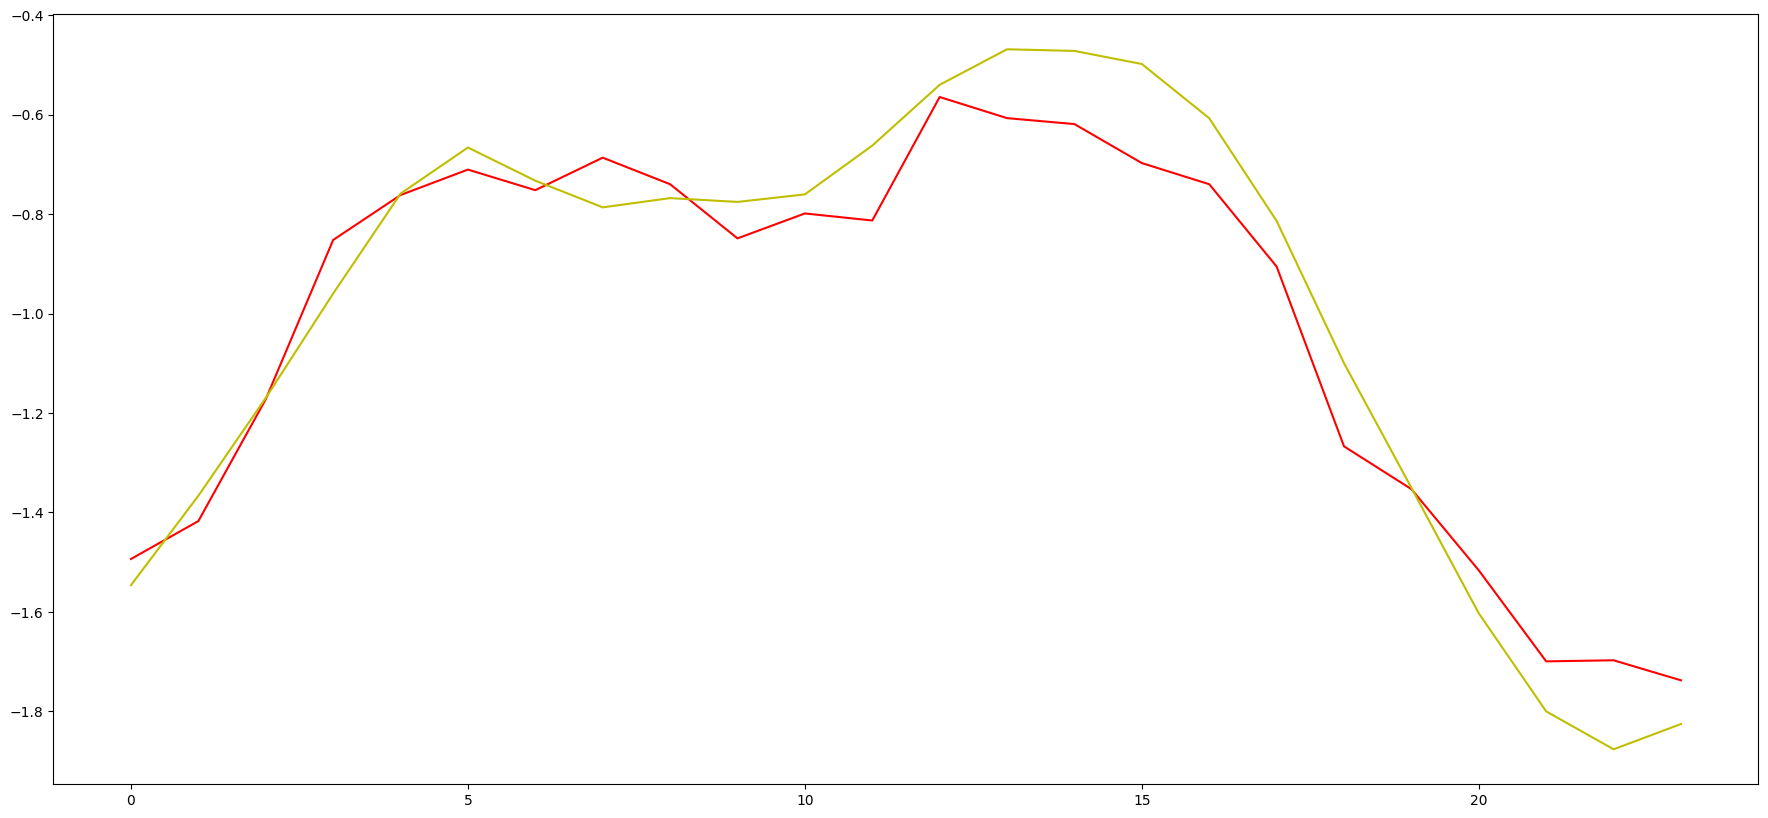

In [31]:
#Now plotting of real vs forecast values.

def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()
plot(y_true,y_pred)

It looks great.This red curve is the actual value and this yellow curve are the predicted values both are pretty much close to each other.
# Therefore the model has been successful in capturing the trend

Implementation of a hybrid Model --- goal ( 2 weeks )